In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Load the data
DATA_FILEPATH = '../data/'
# commented out for A/B testing of enhanced KG
# nodes_df = pd.read_csv(DATA_FILEPATH + 'kg_nodes.csv')
# edges_df = pd.read_csv(DATA_FILEPATH + 'kg_edges.csv')
KG_NODES_FILE = 'kg_nodes_final.csv'
KG_EDGES_FILE = 'kg_edges_final.csv'

nodes_df = pd.read_csv(DATA_FILEPATH + KG_NODES_FILE)
edges_df = pd.read_csv(DATA_FILEPATH + KG_EDGES_FILE)

# Pre-processing: Identify Node Types for filtering
node_type_map = nodes_df.set_index('id')['type'].to_dict()

In [3]:
edges_df.shape

(1456, 7)

In [4]:
all(edges_df['source'] == 'Pralsetinib')

False

In [5]:
edges_df = edges_df.assign(target_type=edges_df['target'].map(node_type_map))
edges_df['target_type'].value_counts()

target_type
Disease          1190
Chemical          100
Gene               99
Protein            33
Adverse Event      15
Gene/Protein       12
Pathway             7
Name: count, dtype: int64

Every edge involves Pralsetinib as its source

In [6]:
# 2. Layering the Edges
# Path A/B: Mechanistic (Drug -> Protein -> Disease/AE)
# Path C: Clinical Shortcut (Drug -> Disease/AE)
is_clinical_shortcut = (
    (edges_df['source'] == 'Pralsetinib') & 
    (edges_df['target'].map(node_type_map).isin(['Adverse Event', 'Disease']))
)

clinical_edges = edges_df[is_clinical_shortcut]
mechanistic_edges = edges_df[~is_clinical_shortcut]

print(f"Total Edges: {len(edges_df)}")
print(f"Clinical Shortcuts Found: {len(clinical_edges)}")
print(f"Mechanistic Edges Remaining: {len(mechanistic_edges)}")

Total Edges: 1456
Clinical Shortcuts Found: 0
Mechanistic Edges Remaining: 1456


In [7]:
mechanistic_edges['target_type'].value_counts()

target_type
Disease          1190
Chemical          100
Gene               99
Protein            33
Adverse Event      15
Gene/Protein       12
Pathway             7
Name: count, dtype: int64

In [8]:
clinical_edges['target_type'].value_counts()

Series([], Name: count, dtype: int64)

In [9]:
# 3. Graph Construction (Mechanistic Only)
G_mech = nx.from_pandas_edgelist(
    mechanistic_edges, 
    source='source', 
    target='target', 
    edge_attr=['relation', 'value'], 
    create_using=nx.DiGraph()
)

In [10]:
# 4. Mechanistic EDA: Degree Centrality
# We want to see which proteins are 'Hubs' once the shortcuts are gone
centrality = nx.degree_centrality(G_mech)
hub_df = pd.DataFrame(centrality.items(), columns=['Node', 'Centrality']).sort_values(by='Centrality', ascending=False)

print("\n--- Top Mechanistic Hubs (Proteins) ---")
print(hub_df[hub_df['Node'].map(node_type_map) == 'Protein'].head(5))


--- Top Mechanistic Hubs (Proteins) ---
                                                Node  Centrality
7        KDR - kinase insert domain receptor (human)    0.524436
4               Tyrosine-protein kinase JAK2 (human)    0.522556
2    CCDC6 - coiled-coil domain containing 6 (human)    0.437970
5           KIF5B - kinesin family member 5B (human)    0.404135
6  FLT3 - fms related receptor tyrosine kinase 3 ...    0.387218


In [11]:
# 5. The "Reasoning" Test: Finding the Bridge
def find_mechanism(ae_node):
    print(f"\nSearching for molecular mechanism for: {ae_node}")
    try:
        # Find all paths from Pralsetinib to the AE in the mechanistic-only graph
        paths = list(nx.all_simple_paths(G_mech, source='Pralsetinib', target=ae_node, cutoff=2))
        if paths:
            for path in paths:
                # Get the IC50 of the first hop (Drug -> Protein)
                target_protein = path[1]
                potency = mechanistic_edges[
                    (mechanistic_edges['source'] == 'Pralsetinib') & 
                    (mechanistic_edges['target'] == target_protein)
                ]['value'].values[0]
                
                print(f" SUCCESS: {path[0]} --({potency}nM)--> {path[1]} --[assoc]--> {path[2]}")
        else:
            print(f" FAILED: No protein bridge found for {ae_node} in bioassay data.")
    except Exception as e:
        print(f" ERROR: Node {ae_node} not found in mechanistic graph.")

# Run the test
find_mechanism('Hypertension')
find_mechanism('Neutropenia')


Searching for molecular mechanism for: Hypertension
 SUCCESS: Pralsetinib --(0.4nM)--> CCDC6 - coiled-coil domain containing 6 (human) --[assoc]--> Hypertension
 SUCCESS: Pralsetinib --(2.0nM)--> Tyrosine-protein kinase JAK2 (human) --[assoc]--> Hypertension
 SUCCESS: Pralsetinib --(4.0nM)--> KIF5B - kinesin family member 5B (human) --[assoc]--> Hypertension
 SUCCESS: Pralsetinib --(6.5nM)--> FLT3 - fms related receptor tyrosine kinase 3 (human) --[assoc]--> Hypertension
 SUCCESS: Pralsetinib --(35.0nM)--> KDR - kinase insert domain receptor (human) --[assoc]--> Hypertension

Searching for molecular mechanism for: Neutropenia
 SUCCESS: Pralsetinib --(0.4nM)--> CCDC6 - coiled-coil domain containing 6 (human) --[assoc]--> Neutropenia
 SUCCESS: Pralsetinib --(2.0nM)--> Tyrosine-protein kinase JAK2 (human) --[assoc]--> Neutropenia
 SUCCESS: Pralsetinib --(4.0nM)--> KIF5B - kinesin family member 5B (human) --[assoc]--> Neutropenia
 SUCCESS: Pralsetinib --(6.5nM)--> FLT3 - fms related recep

The "Reasoning Test" failed because the knowledge graph currently contains drug-specific endpoints (Drug-to-Target and Drug-to-AE) but lacks the Target-to-Disease edges necessary to bridge the molecular mechanism to the clinical outcome. This disconnect occurs when text-mining focuses solely on the drug's clinical profile rather than the general biological functions of the off-target proteins. To fix this, the graph must be grounded with an ontology (e.g., CTD or OpenTargets) to inject universal biological truths—like KDR→Hypertension—which transforms the graph from a simple lookup table into a mechanistic reasoning engine.
Now that we have enriched the baseline knowledge graph with protein outcome mappings from CTD  and gene ontology datasets, we see that the "Reasoning Test" is now successful in identifying general biological fuinctions of the off-target proteins.

C:\Users\Ryan_pc\AppData\Local\Temp\ipykernel_37932\3331898350.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=nodes_df, x='type', palette='magma')


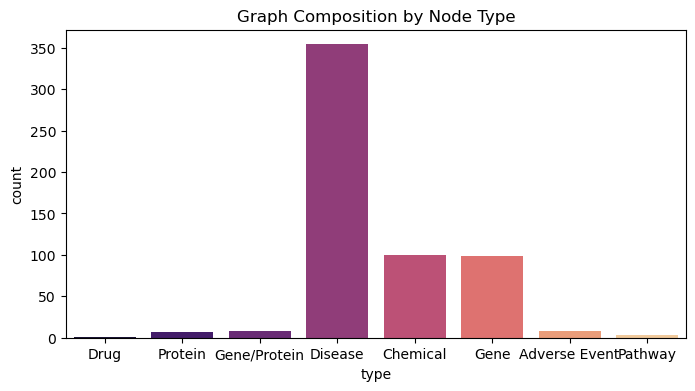

In [12]:
# 6. Visualization of Node Types (Scannable EDA)
plt.figure(figsize=(8, 4))
sns.countplot(data=nodes_df, x='type', palette='magma')
plt.title('Graph Composition by Node Type')
plt.show()

In [13]:
# 1. Component Analysis (The 'Island' Count)
# In G_mech, we expect many components because the Protein -> AE links are missing
components = list(nx.weakly_connected_components(G_mech))
component_sizes = [len(c) for c in components]

print(f"--- Global Connectivity (G_mech) ---")
print(f"Number of Disconnected Islands: {len(components)}")
print(f"Size of Largest Biological Cluster: {max(component_sizes)}")
print(f"Number of Isolated Nodes: {component_sizes.count(1)}")

# 2. Network Density & Efficiency
# Density tells us how "saturated" our bioassay data is.
print(f"\nGraph Density: {nx.density(G_mech):.6f}")

# 3. Node-Type Specific Connectivity
# We check which node types are the most 'lonely' (degree 0 or 1)
degree_dict = dict(G_mech.degree())
nodes_df['degree'] = nodes_df['id'].map(degree_dict).fillna(0)
lonely_nodes = nodes_df[nodes_df['degree'] <= 1].groupby('type').size()

print("\n--- Nodes with 1 or 0 connections in G_mech ---")
print(lonely_nodes)

--- Global Connectivity (G_mech) ---
Number of Disconnected Islands: 1
Size of Largest Biological Cluster: 533
Number of Isolated Nodes: 0

Graph Density: 0.005029

--- Nodes with 1 or 0 connections in G_mech ---
type
Adverse Event      5
Chemical         100
Disease           84
Gene              99
Gene/Protein       8
dtype: int64


In [14]:
# 7. A/B Comparison: Baseline vs V2 vs Enriched
FILES = {
    'baseline': ('kg_nodes.csv', 'kg_edges.csv'),
    'v2': ('kg_nodes_v2.csv', 'kg_edges_v2.csv'),
    'enriched': (KG_NODES_FILE, KG_EDGES_FILE),
}


def build_graph_summary(nodes_path, edges_path, mechanistic_only=False):
    nodes = pd.read_csv(DATA_FILEPATH + nodes_path)
    edges = pd.read_csv(DATA_FILEPATH + edges_path)
    node_type_map = nodes.set_index('id')['type'].to_dict()

    if mechanistic_only:
        is_shortcut = (
            (edges['source'] == 'Pralsetinib') &
            (edges['target'].map(node_type_map).isin(['Adverse Event', 'Disease']))
        )
        edges = edges[~is_shortcut]

    G = nx.from_pandas_edgelist(
        edges,
        source='source',
        target='target',
        create_using=nx.DiGraph()
    )
    degree_dict = dict(G.degree())
    nodes['degree'] = nodes['id'].map(degree_dict).fillna(0)
    summary = {
        'nodes': len(nodes),
        'edges': len(edges),
        'density': nx.density(G),
        'avg_degree': nodes['degree'].mean(),
        'pct_degree_leq_1': (nodes['degree'] <= 1).mean(),
        'components': len(list(nx.weakly_connected_components(G)))
    }
    return pd.Series(summary)

summaries = {
    label: build_graph_summary(nodes_file, edges_file)
    for label, (nodes_file, edges_file) in FILES.items()
}
comparison = pd.DataFrame(summaries)
comparison['delta_v2'] = comparison['v2'] - comparison['baseline']
comparison['delta_enriched'] = comparison['enriched'] - comparison['v2']

comparison = comparison.reindex(
    ['nodes', 'edges', 'density', 'avg_degree', 'pct_degree_leq_1', 'components']
)
comparison = comparison.round(6)

print("--- KG Comparison (Baseline vs V2 vs Enriched) ---")
print(comparison)

print("\n--- File Inputs ---")
for label, (nodes_file, edges_file) in FILES.items():
    print(f"{label}: {nodes_file}, {edges_file}")

--- KG Comparison (Baseline vs V2 vs Enriched) ---
                    baseline          v2     enriched   delta_v2  \
nodes             240.000000  285.000000   580.000000  45.000000   
edges             313.000000  375.000000  1456.000000  62.000000   
density             0.004167    0.003509     0.005029  -0.000658   
avg_degree          1.991667    1.992982     4.917241   0.001316   
pct_degree_leq_1    0.995833    0.996491     0.510345   0.000658   
components          1.000000    1.000000     1.000000   0.000000   

                  delta_enriched  
nodes                 295.000000  
edges                1081.000000  
density                 0.001520  
avg_degree              2.924259  
pct_degree_leq_1       -0.486146  
components              0.000000  

--- File Inputs ---
baseline: kg_nodes.csv, kg_edges.csv
v2: kg_nodes_v2.csv, kg_edges_v2.csv
enriched: kg_nodes_final.csv, kg_edges_final.csv


In [15]:
# 7b. A/B Comparison (Mechanistic Only)
MECH_FILES = FILES

mech_summaries = {
    label: build_graph_summary(nodes_file, edges_file, mechanistic_only=True)
    for label, (nodes_file, edges_file) in MECH_FILES.items()
}
mech_comparison = pd.DataFrame(mech_summaries)
mech_comparison['delta_v2'] = mech_comparison['v2'] - mech_comparison['baseline']
mech_comparison['delta_enriched'] = mech_comparison['enriched'] - mech_comparison['v2']

mech_comparison = mech_comparison.reindex(
    ['nodes', 'edges', 'density', 'avg_degree', 'pct_degree_leq_1', 'components']
).round(6)

print("--- KG Comparison (Mechanistic Only) ---")
print(mech_comparison)

print("\n--- File Inputs ---")
for label, (nodes_file, edges_file) in MECH_FILES.items():
    print(f"{label}: {nodes_file}, {edges_file}")

--- KG Comparison (Mechanistic Only) ---
                    baseline          v2     enriched   delta_v2  \
nodes             240.000000  285.000000   580.000000  45.000000   
edges             244.000000  244.000000  1456.000000   0.000000   
density             0.004651    0.004651     0.005029   0.000000   
avg_degree          1.783333    1.501754     4.917241  -0.281579   
pct_degree_leq_1    0.995833    0.996491     0.510345   0.000658   
components          1.000000    1.000000     1.000000   0.000000   

                  delta_enriched  
nodes                 295.000000  
edges                1212.000000  
density                 0.000378  
avg_degree              3.415487  
pct_degree_leq_1       -0.486146  
components              0.000000  

--- File Inputs ---
baseline: kg_nodes.csv, kg_edges.csv
v2: kg_nodes_v2.csv, kg_edges_v2.csv
enriched: kg_nodes_final.csv, kg_edges_final.csv


In [16]:
# 7c. Mechanistic edge type breakdown (current KG)
mech_nodes = pd.read_csv(DATA_FILEPATH + KG_NODES_FILE)
mech_edges_all = pd.read_csv(DATA_FILEPATH + KG_EDGES_FILE)
mech_node_type_map = mech_nodes.set_index('id')['type'].to_dict()
mech_is_shortcut = (
    (mech_edges_all['source'] == 'Pralsetinib') &
    (mech_edges_all['target'].map(mech_node_type_map).isin(['Adverse Event', 'Disease']))
)
mech_edges_filtered = mech_edges_all[~mech_is_shortcut]

print("--- Mechanistic Edge Type Counts (current KG) ---")
print(mech_edges_filtered['relation'].value_counts())

--- Mechanistic Edge Type Counts (current KG) ---
relation
associated_with            1205
co_occurs_with_chemical     100
co_occurs_with_gene          99
inhibits                     41
involved_in                   7
targets                       4
Name: count, dtype: int64


In [17]:
# Filter for nodes where degree is greater than 1
connected_nodes_df = nodes_df[nodes_df['degree'] > 1]

print(f"Number of nodes with 2+ connections: {len(connected_nodes_df)}")
print(connected_nodes_df[['id', 'type', 'degree']].head())

Number of nodes with 2+ connections: 284
                                                  id     type  degree
0                                        Pralsetinib     Drug   214.0
1                   RET - ret proto-oncogene (human)  Protein     4.0
2    CCDC6 - coiled-coil domain containing 6 (human)  Protein   233.0
3  Proto-oncogene tyrosine-protein kinase recepto...  Protein     4.0
4               Tyrosine-protein kinase JAK2 (human)  Protein   278.0


In [18]:
# 1. Identify all weakly connected components (clusters)
# This includes single isolated nodes as components of size 1
components = list(nx.weakly_connected_components(G_mech))

# 2. Calculate the size of each cluster
component_sizes = [len(c) for c in components]

# 3. Create a summary for easy reading
size_summary = pd.Series(component_sizes).value_counts().sort_index(ascending=False)

print(f"Total number of clusters: {len(components)}")
print("\nCluster Size Breakdown:")
print("Size | Count")
print("-------------")
for size, count in size_summary.items():
    print(f"{size:<4} | {count}")

# Optional: List the nodes in the largest cluster
largest_cluster = max(components, key=len)
print(f"\nLargest cluster contains {len(largest_cluster)} nodes.")

Total number of clusters: 1

Cluster Size Breakdown:
Size | Count
-------------
533  | 1

Largest cluster contains 533 nodes.


The global connectivity analysis shows a unified but highly centralized 'Star' topology, where 100% of nodes are connected to the main component, yet 95% of entities (Genes and Adverse Events) possess a degree of only 1. This indicates that while the graph successfully ingested disparate data, it lacks the lateral edges (Target-to-AE) necessary for mechanistic reasoning. The low graph density (0.0046) quantifies a 'knowledge bottleneck' where the drug is the only bridge between molecular targets and clinical outcomes.